In [1]:
import  time
from    tqdm.notebook           import  tqdm

import  torch
from    torch                   import  Tensor
import  matplotlib.pyplot       as      plt
from    IPython                 import  display
from    ipywidgets              import  Output

import  append_path
from    deep_numerical.utils                   import  *
from    deep_numerical.numerical.distribution  import  *
from    deep_numerical.numerical.solvers       import  *

DTYPE:  torch.dtype     = torch.double
DEVICE: torch.device    = torch.device('cuda:3')
tensor_kwargs = {'dtype': DTYPE, 'device': DEVICE}

In [2]:
# Time
DELTA_T:    float       = 0.01
MIN_T:      float       = 0.0
MAX_T:      float       = 6.0
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      Tensor      = torch.linspace(MIN_T, MAX_T, NUM_T, **tensor_kwargs)

# Velocity
DIMENSION:      int         = 2
RESOLUTION:     int         = 2**5
MAX_V:          float       = 3.0 / LAMBDA
V:              Tensor      = velocity_grid(
                                    DIMENSION,
                                    RESOLUTION,
                                    MAX_V,
                                    where_closed='left',
                                    **tensor_kwargs
                                )

# Further configurations - FFT
FFT_NORM:   str         = 'forward'
_FREQ:      Tensor      = fft_index(RESOLUTION, **tensor_kwargs)
FREQ_MIN:   int         = int(_FREQ.min())
FREQ_MAX:   int         = int(_FREQ.max())
freqs:      Tensor      = freq_tensor(DIMENSION, RESOLUTION, **tensor_kwargs)
    
# VHS model
VSS_COEFF:      float   = 1 / area_of_unit_sphere(DIMENSION)
VSS_EXP_SPEED:  float   = 0.38
VSS_EXP_ANGLE:  float   = 0.70

# Metric
METRIC_ORDER:   float   = float('1')

# Problem type
PROBLEM_TYPE:   str = 'maxwellian' # 'bimaxwellian', 'bkw', 'maxwellian'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = get_bkw_coeff_ext(DIMENSION)

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = torch.ones((1,1), **tensor_kwargs)
MAXWELLIAN_MEAN_VELOCITY:       Tensor      = torch.zeros((1,DIMENSION), **tensor_kwargs)
MAXWELLIAN_MEAN_TEMPERATURE:    float       = torch.ones((1,1), **tensor_kwargs)

## Bimaxwellian distribution
BIMAXWELLIAN_MODE1_MEAN_DENSITY:     float       = 0.5 * torch.ones((1,1), **tensor_kwargs)
BIMAXWELLIAN_MODE1_MEAN_VELOCITY:    Tensor      = torch.tensor([[MAX_V/6, *zeros(DIMENSION-1)]], **tensor_kwargs)
BIMAXWELLIAN_MODE1_MEAN_TEMPERATURE: float       = 0.5 * torch.ones((1,1), **tensor_kwargs)

In [3]:
print(f"[ Initialization ]")
print(f"* Setting the initial value.")
init_f: Tensor
arr_f:  Tensor
if PROBLEM_TYPE == 'bkw':
    bkw_sol = bkw(
        ARR_T, V,
        coeff_ext   = BKW_COEFF_EXT,
        vhs_coeff   = VSS_COEFF,
    )
    init_f = bkw_sol[:, 0]
elif PROBLEM_TYPE == 'maxwellian':
    init_f = maxwellian_homogeneous(
        V,
        MAXWELLIAN_MEAN_DENSITY,
        MAXWELLIAN_MEAN_VELOCITY,
        MAXWELLIAN_MEAN_TEMPERATURE,
    )
elif PROBLEM_TYPE == 'bimaxwellian':
    init_f = maxwellian_homogeneous(
        V,
        BIMAXWELLIAN_MODE1_MEAN_DENSITY,
        +BIMAXWELLIAN_MODE1_MEAN_VELOCITY,
        BIMAXWELLIAN_MODE1_MEAN_TEMPERATURE,
    ) + \
    maxwellian_homogeneous(
        V,
        BIMAXWELLIAN_MODE1_MEAN_DENSITY,
        -BIMAXWELLIAN_MODE1_MEAN_VELOCITY,
        BIMAXWELLIAN_MODE1_MEAN_TEMPERATURE,
    )
arr_f = init_f

print(f"* Computing the kernel components.")
sm_object = FastSM_Boltzmann_VSS(
    dimension   = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = MAX_V,
    vss_coeff       = VSS_COEFF,
    vss_exp_speed   = VSS_EXP_SPEED,
    vss_exp_angle   = VSS_EXP_ANGLE,
    restitution = 1.0,
    
    quad_order_uniform=100,
    # quad_order_legendre=int(0.7*RESOLUTION),
    dtype   = DTYPE,
    device  = DEVICE,
)
print(f"\tDone. (approximation level: {sm_object.approximation_level})")

fft_config = {'s': sm_object.v_shape, 'dim': sm_object.v_axes, 'norm': FFT_NORM}
arr_f_fft: Tensor = torch.fft.fftn(arr_f, **fft_config)

[ Initialization ]
* Setting the initial value.
* Computing the kernel components.
	Done. (approximation level: 3200)


In [4]:
# Define the function which returns the target
def return_target(t_idx: int) -> Tensor:
    if PROBLEM_TYPE == 'bkw':
        # Return the BKW solution at the given time index
        return bkw_sol[:, t_idx]
    elif PROBLEM_TYPE == 'maxwellian':
        # Return the initial value, which is the Maxwellian distribution
        return init_f
    elif PROBLEM_TYPE == 'bimaxwellian':
        # Return the Maxwellian distribution
        _batch_size, _data_dim = init_f.size(0), init_f.size(-1)
        _moments = compute_moments_homogeneous(init_f, V)
        return maxwellian_homogeneous(V, *_moments).reshape(
            _batch_size, *ones(DIMENSION), *sm_object.v_shape, _data_dim
        )

In [5]:
# Define storages
arr_distribution        = []
arr_mean_density        = []
arr_mean_velocity       = []
arr_mean_temperature    = []
arr_rel_error           = []


# Define the function which updates the storages
def update_storages(t_idx: int, f: Tensor) -> None:
    _mean_density, _mean_velocity, _mean_temperature = \
        compute_moments_inhomogeneous(f, V, eps=1e-20)
    _target = return_target(t_idx)
    _rel_error = relative_error(f, _target, p=METRIC_ORDER)
    
    arr_distribution.append(f)
    arr_mean_density.append(_mean_density)
    arr_mean_velocity.append(_mean_velocity)
    arr_mean_temperature.append(_mean_temperature)
    arr_rel_error.append(_rel_error)
    
    return

In [6]:
print(f"[ Computation ]")
print(f"* Computing the numerical solution.")
_idx_start = 1
out = Output()
display.display(out)

elapsed_time = time.time()
update_storages(0, init_f)
for t_idx, t_curr in enumerate(tqdm(ARR_T[_idx_start:]), _idx_start):
    """Time marching from the temporal index `t_idx-1` to `t_idx`"""
    # Conduct time-marching
    t_prev = float(ARR_T[t_idx-1])
    arr_f_fft = sm_object.forward(t_prev, arr_f_fft, DELTA_T, one_step_RK4_classic)
    arr_f = torch.fft.ifftn(arr_f_fft, **fft_config).real
    # Save data
    update_storages(t_idx, arr_f)
elapsed_time = time.time() - elapsed_time
print(f"\tDone. (Elapsed time: {elapsed_time:.2f} seconds)")

print(f"* Stacking the results into tensors.")
ARR_T                   = ARR_T.cpu()
V                       = V.cpu()
arr_distribution        = torch.stack(arr_distribution, dim=1).cpu()
arr_mean_density        = torch.stack(arr_mean_density, dim=1).cpu()
arr_mean_velocity       = torch.stack(arr_mean_velocity, dim=1).cpu()
arr_mean_temperature    = torch.stack(arr_mean_temperature, dim=1).cpu()
arr_rel_error           = torch.stack(arr_rel_error, dim=1).cpu()
print(f"\tDone.")

[ Computation ]
* Computing the numerical solution.


Output()

  0%|          | 0/600 [00:00<?, ?it/s]

	Done. (Elapsed time: 7.41 seconds)
* Stacking the results into tensors.
	Done.


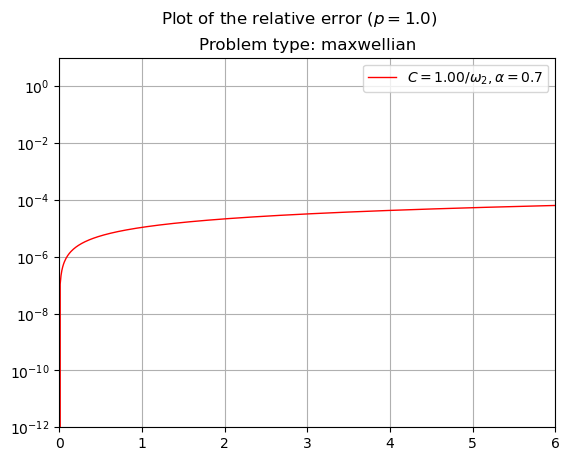

In [7]:
_C_times_omega_d = VSS_COEFF*area_of_unit_sphere(DIMENSION)
plt.plot(
    ARR_T, *arr_rel_error,
    'r-', linewidth=1,
    label=rf"$C={(_C_times_omega_d):.2f}/\omega_{DIMENSION}, \alpha={VSS_EXP_ANGLE:.1f}$")
plt.suptitle(f"Plot of the relative error ($p={METRIC_ORDER}$)")
plt.title(f"Problem type: {PROBLEM_TYPE}")
plt.xlim(MIN_T, MAX_T)
plt.ylim(1e-12, 1e+1)
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()

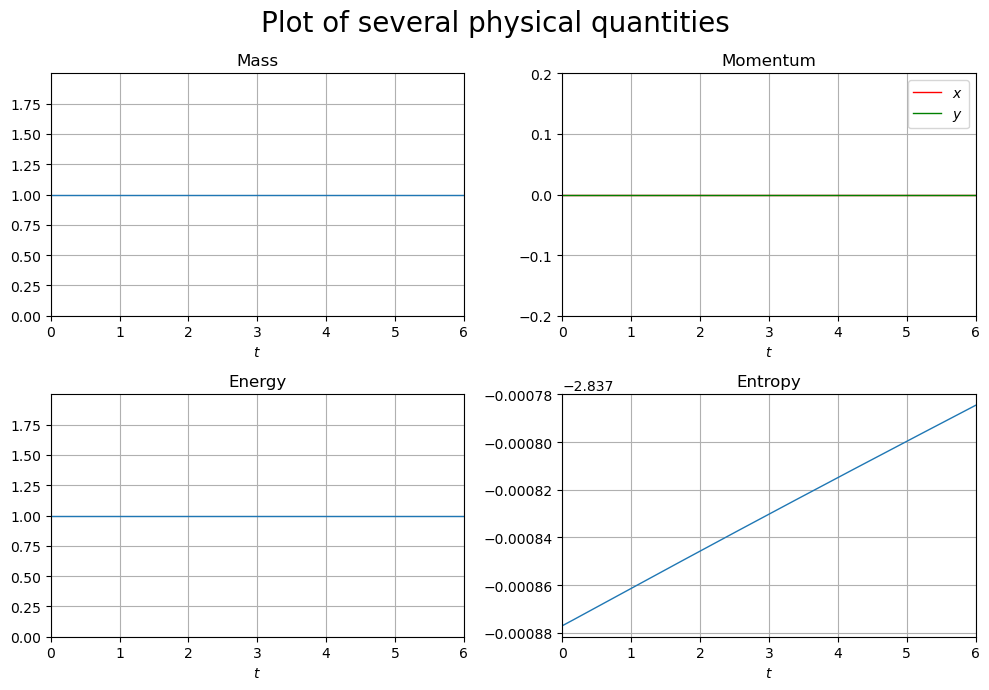

In [8]:
fig, axes = plot_quantities_homogeneous(arr_distribution[0], v_grid=V, arr_t=ARR_T)
fig.show()

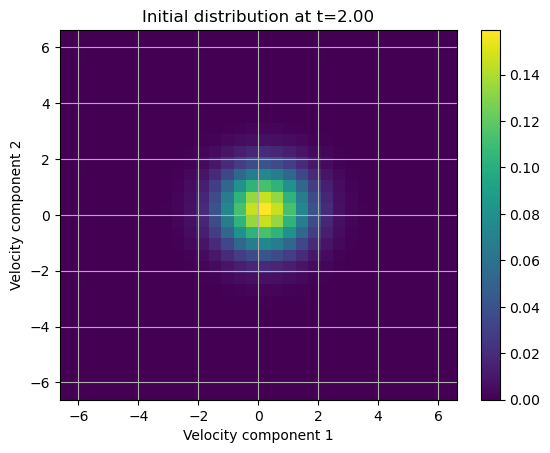

In [9]:
t_idx = 200
plt.imshow(arr_distribution[0, t_idx].reshape(RESOLUTION, RESOLUTION).cpu().numpy(),
           extent=[-MAX_V, MAX_V, -MAX_V, MAX_V],
           origin='lower', aspect='auto',
           cmap='viridis')
plt.colorbar()
plt.title(f"Initial distribution at t={ARR_T[t_idx]:.2f}")
plt.xlabel("Velocity component 1")
plt.ylabel("Velocity component 2")
plt.xlim(-MAX_V, MAX_V)
plt.ylim(-MAX_V, MAX_V)
plt.grid(True)
plt.show()

End of file